#Miljødataanalyse - Kode Del

In [265]:
#denne kan fjernes
import pandas as pd

# Read the CSV file
weather_data = pd.read_csv("../data/weather_data.csv")

# View the first 5 rows
weather_data.head()


,time,temperature,humidity,wind_speed_mps,cloud_cover,pressure
0,2025-04-21 10:00:00+00:00,9.4,63.0,2.2,92.6,1012.4
1,2025-04-21 11:00:00+00:00,10.2,60.0,2.2,94.0,1012.5
2,2025-04-21 12:00:00+00:00,11.1,58.0,2.3,94.8,1012.5
3,2025-04-21 13:00:00+00:00,11.7,55.0,1.9,95.5,1012.6
4,2025-04-21 14:00:00+00:00,12.4,53.0,1.8,98.7,1012.5


In [266]:
import requests
import pandas as pd
import os
from pandasql import sqldf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
"""
Jeg måtte kjøre pip install pandasql i en egen notebook-celle
 for å få det til å funke, det gikk ikke å bare installere i terminal. 
 Jeg slettet den etterpå, men om det ikke funker for dere kan dere prøve det.
"""

'\nJeg måtte kjøre pip install pandasql i en egen notebook-celle\n for å få det til å funke, det gikk ikke å bare installere i terminal. \n Jeg slettet den etterpå, men om det ikke funker for dere kan dere prøve det.\n'

In [267]:
"""Oppgave 2 Datainnsamling"""
"""
Hentet fra: https://api.met.no/ mer spesifikt hentet jeg API-en fra:
 https://api.met.no/weatherapi/locationforecast/2.0/documentation
"""


url = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
# Denne API krever user agent, står på nettsiden
headers = {
    "User-Agent": "Gruppe43"
    #"Id-Modified_Since": "2024-04-21"
    #Oppdater ID-midified since hver dag
}

params = {
    "lat": 63.4305,
    "lon": 10.3951
}

res = requests.get(url, headers=headers, params=params)
data = res.json()

timeseries = data["properties"]["timeseries"] #Gir en liste av værdata per time 

weather_data = [
    {
        "time": entry["time"],
        "temperature": entry["data"]["instant"]["details"].get("air_temperature"),
        "humidity": entry["data"]["instant"]["details"].get("relative_humidity"),
        "wind_speed": entry["data"]["instant"]["details"].get("wind_speed"),
        "cloud_cover": entry["data"]["instant"]["details"].get("cloud_area_fraction"),
        "pressure": entry["data"]["instant"]["details"].get("air_pressure_at_sea_level"),
    }
    for entry in timeseries  # loop gjennom værmeldingen for hver time
]

df = pd.DataFrame(weather_data) # Gjør om til pandas dataframe (Gjør det til en tabell)

#Bruke pandasql for å finne 10 varmeste tidene (Den sto i oppgaven vi måtte bruke pandasql så jeg bare la noe til, vi kan endre på det senere)
query = "SELECT time, temperature FROM df WHERE temperature IS NOT NULL ORDER BY temperature DESC LIMIT 10"
result = sqldf(query)
print(result)



                   time  temperature
0  2025-05-27T12:00:00Z         18.5
1  2025-05-27T18:00:00Z         17.2
2  2025-05-26T12:00:00Z         16.8
3  2025-05-30T12:00:00Z         16.0
4  2025-05-26T18:00:00Z         15.6
5  2025-05-29T12:00:00Z         15.6
6  2025-05-25T18:00:00Z         15.5
7  2025-05-24T12:00:00Z         15.3
8  2025-05-25T12:00:00Z         15.2
9  2025-05-28T12:00:00Z         15.2


In [ ]:
"""Forsøk på å lagre eldre data fra API-en"""

def oppdater_lagringsfil(ny_df, filnavn="../data/lagret_data.csv"): 
    """
    Oppdaterer en lokal CSV-fil med nye API-data og unngår duplikater basert på tid.
    Alle tidspunkter konverteres til samme format (YYYY-MM-DD HH:MM:SS)
    """
    #ny_df: Midlertidig DataFrame med nye værdata
    #filnavn: Navnet og location på nye CSV-filen som lagrer dataene

    #Sørger for at 'time' i ny_df er i datetime-format uten tidssone og med samme strengformat
    ny_df["time"] = pd.to_datetime(ny_df["time"]).dt.tz_convert(None)
    ny_df["time"] = ny_df["time"].dt.strftime("%Y-%m-%d %H:%M:%S")

    #Hvis filen finnes fra før
    if os.path.exists(filnavn):
        eksisterende = pd.read_csv(filnavn)
        #Gjør det samme med eksisterende data
        eksisterende["time"] = pd.to_datetime(eksisterende["time"], errors="coerce")
        eksisterende["time"] = eksisterende["time"].dt.strftime("%Y-%m-%d %H:%M:%S")
        #Kombinerer og fjerner duplikater basert på tidspunkt
        kombinert = pd.concat([eksisterende, ny_df])
        kombinert = kombinert.drop_duplicates(subset="time", keep="last")
    else:
        kombinert = ny_df #Hvis filen ikke finnes, bruker bare den nye dataen
    
    kombinert.to_csv(filnavn, index=False) #Lagrer resultatet tilbake til CSV-filen
    print(f"Lagret {len(kombinert)} rader i '{filnavn}'") #Printer antall rader etter oppdatering
    return kombinert  #Returnerer hele datasettet til videre bruk

df_stor = oppdater_lagringsfil(df) #Dette er datasettet med eldre og nye data

#Lagret 87 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:00
#Lagret 174 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:11 (hmmm ser ikke rett ut)
#Lagret 260 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:26 (huh)
#Slettet og lagde på nytt med konsistent formatering
#Lagret 86 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:32
#Lagret 172 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:33 (hmmmmmmmm)
#Slettet igjen og kjørte på nytt med nye endringer
#Lagret 86 rader i '../data/lagret_data.csv' 20.05.2025 klokken 13:44
#Lagret 87 rader i '../data/lagret_data.csv' 20.05.2025 klokken 15:49
#Lagret 92 rader i '../data/lagret_data.csv' 20.05.2025 klokken 18:00

✅ Lagret 92 rader i '../data/lagret_data.csv'


In [269]:
"""Forsøk på å skape manglende verdier"""
def legg_til_manglende_verdier(df_stor, min_prosent=0.01, max_prosent=0.05):
    """
    Fjerner tilfeldig prosentandel verdier fra hver 
    kolonne, (ikke 'time') for å simulere manglende data
    """
    #min/max_prosent: minimun og maksimum prosentandel av verdiene (per kolonne) som kan fjernes 
    #(default: 5% burde kanskje justeres om datasettet blir større)
    df = df_stor.copy()
    #Lager en liste over kolonner som skal påvirkes (alle unntatt 'time'):
    kolonner = [col for col in df.columns if col != "time"]

    for kol in kolonner:  #Går gjennom hver av kolonnene og legger til manglende verdier
        #Velger en tilfeldig prosentandel mellom min og maks slik at det ikke er likt for alle kolonnene:
        prosent = random.uniform(min_prosent, max_prosent) 
        antall = int(len(df) * prosent)  #Beregner hvor mange verdier som skal fjernes (f.eks. 5% av rader)
        indeks = df.sample(n=antall).index  #Velger tilfeldig hvilke rader som skal få NaN
        df.loc[indeks, kol] = np.nan #Gjør verdiene i den aktuelle kolonnen om til NaN på de valgte radene

    return df #Returner den ødelagte df med "simulert" manglende data

df_broken = legg_til_manglende_verdier(df_stor) 

In [270]:
"""Oppgave 3 Databehandling"""

def vis_manglende_verdier(df_broken):
    """Finner og viser manglende verdier per kolonne"""
    manglende = df_broken.isnull().sum()
    total_mangler = manglende.sum()

    if total_mangler == 0:
        print("Det er ingen manglende verdier i datasettet.")
    else:
        print("Manglende verdier per kolonne:")
        print(manglende[manglende > 0])

def rens_data(df_broken):
    """Renser manglende og ugyldige verdier"""
    df_broken = df_broken.copy()

    #Går gjennom alle kolonner unntatt 'time' 
    #og fyller inn NaN med gjennomsnittsverdi for kolonnen
    for kol in df_broken.columns:
        if kol != "time" and df_broken[kol].isnull().any():
            gjennomsnitt = df_broken[kol].mean()
            df_broken[kol] = df_broken[kol].fillna(gjennomsnitt)


    #Dette er eksempler på data rensing som ikke er helt relevante:

    #Fjerner rader med ugyldig fuktighet (over 100 eller under 0)
    df_broken = df_broken[(df_broken["humidity"] >= 0) & (df_broken["humidity"] <= 100)]

    #Erstatt ekstreme temperaturer som ikke er mulig/ gir mening med NaN
    df_broken.loc[df_broken["temperature"] < -60, "temperature"] = pd.NA
    df_broken.loc[df_broken["temperature"] > 60, "temperature"] = pd.NA

    return df_broken

def formater_data(df_broken):
    """Formaterer dataene for å gjøre dem mer strukturert og leselig"""
    df_broken = df_broken.copy()

    #Gjør 'time' til datetime
    df_broken["time"] = pd.to_datetime(df_broken["time"], errors="coerce")

    #Runder verdier for lesbarhet
    df_broken["temperature"] = df_broken["temperature"].round(1)
    df_broken["humidity"] = df_broken["humidity"].round(0)

    if "wind_speed" in df_broken.columns:
        df_broken["wind_speed"] = df_broken["wind_speed"].round(1)
        df_broken.rename(columns={"wind_speed": "wind_speed_mps"}, inplace=True)
    elif "wind_speed_mps" in df_broken.columns:
        df_broken["wind_speed_mps"] = df_broken["wind_speed_mps"].round(1)

    #Gir nye navn til kolonner om vi vil
    df_broken.rename(columns={"wind_speed": "wind_speed_mps"}, inplace=True)

    #Endre rekkefølgen på kolonnene
    kolonne_rekkefølge = ["time", "temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]
    df_broken = df_broken[[col for col in kolonne_rekkefølge if col in df_broken.columns]]

    return df_broken

def flagg_kuldegrader(df_broken):
    """Legger til kolonne som viser om temperaturen er under 0 grader"""
    df_broken = df_broken.copy()
    df_broken["Kuldegrader"] = df_broken["temperature"].apply(lambda t: t < 0 if pd.notnull(t) else False)
    return df_broken

def prepare_data(df_broken):
    """Kjører alle steg: viser, renser, formaterer og legger til kolonne for kuldegrader"""
    df_broken = rens_data(df_broken)
    df_broken = formater_data(df_broken)
    df_broken = flagg_kuldegrader(df_broken)
    #vis_manglende_verdier(df_broken) Trenger kanskje ikke være med
    return df_broken


vis_manglende_verdier(df_broken) #før fikset
df_fiks = rens_data(df_broken)
vis_manglende_verdier(df_fiks)  #etter fikset

df_fixed = prepare_data(df_broken)

#query = "SELECT time, temperature FROM df_cleaned WHERE temperature IS NOT NULL ORDER BY time DESC LIMIT 10"
#result = sqldf(query)
#print(result)

Manglende verdier per kolonne:
temperature    3
humidity       3
wind_speed     3
cloud_cover    2
pressure       1
dtype: int64
Det er ingen manglende verdier i datasettet.


In [271]:
#kan fjernes 
#Ferdig formatert df file
formatert_df = formater_data(df_stor)

#Del 1: Merge eksisteredne csv filen med en ny csv fil som innehodler nytt data
main_file = pd.read_csv('../data/weather_data.csv')
temp_file = pd.DataFrame(formatert_df).to_csv("../data/temp_weather_data.csv", index=False)
temp_file = pd.read_csv('../data/temp_weather_data.csv')
        
main_file.merge(temp_file)

#Del 2: Droppe duplicates fra den sammenslåtte filen
#- "subset" alle columns er brukt 
#- "inplace" data strukturen er forrandret, og duplikater er vekke

main_file.drop_duplicates(subset=None, inplace=True)

# Read the CSV file
weather_data = pd.read_csv("../data/weather_data.csv")

# View the first 5 rows
weather_data.head(40)

,time,temperature,humidity,wind_speed_mps,cloud_cover,pressure
0,2025-04-21 10:00:00+00:00,9.4,63.0,2.2,92.6,1012.4
1,2025-04-21 11:00:00+00:00,10.2,60.0,2.2,94.0,1012.5
2,2025-04-21 12:00:00+00:00,11.1,58.0,2.3,94.8,1012.5
3,2025-04-21 13:00:00+00:00,11.7,55.0,1.9,95.5,1012.6
4,2025-04-21 14:00:00+00:00,12.4,53.0,1.8,98.7,1012.5
5,2025-04-21 15:00:00+00:00,13.0,53.0,1.6,99.5,1012.6
6,2025-04-21 16:00:00+00:00,13.0,58.0,1.9,99.2,1012.6
7,2025-04-21 17:00:00+00:00,12.7,59.0,2.2,98.4,1012.7
8,2025-04-21 18:00:00+00:00,11.9,63.0,1.6,97.4,1012.9
9,2025-04-21 19:00:00+00:00,10.7,65.0,0.7,98.2,1013.2


In [272]:
"""Oppgave 4 Dataanalyse"""
#Her bruker jeg både NumPy og Pandas for å beregne gjennomsnitt, median og standardavvik.

def vis_statistikk(df_fixed):
    """Finner og viser gjennomsnitt, median og standardavvik for utvalgte variabler"""
    print("Gjennomsnitt:")
    print(df_fixed[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].mean())

    print("\nMedian:")
    print(df_fixed[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].median())

    print("\nStandardavvik:")
    print(df_fixed[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].std())

def analyse_temperaturfordeling(df_fixed):
    """Bruker NumPy til å finne gjennomsnittlig fordeling av temperaturverdier"""
    datas = df_fixed["temperature"].dropna().values
    mean = np.mean(datas)
    median = np.median(datas)
    std = np.std(datas)

    print("\nGjennomsnittlig temperaturfordeling:")
    print(f" - Gjennomsnitt temperatur: {mean:.2f}°C")
    print(f" - Median: {median:.2f}°C")
    print(f" - Standardavvik: {std:.2f}°C")

    if mean > median:
        print(" - Det er flere lave temperaurer")
    elif mean < median:
        print(" - Det er flere varme temperaturer")
    else:
        print(" - Temperaturfordelingen er gjevn")

vis_statistikk(df_fixed)

analyse_temperaturfordeling(df_fixed)

#Lineær regjresjonsanalyse her kanskje?

#Viser mønster at temperaturen er konsekvent lavere om natten :)
def analyser_dagstemperatur(df_fixed):
    """Sammenligner gjennomsnittstemperatur mellom natt (20:00–06:00) og dag (07:00–19:00)"""
    df_fixed = df_fixed.copy() #Lager kopi
    df_fixed["hour"] = df_fixed["time"].dt.hour  # Henter timeverdi fra tid 

    def natt_eller_dag(hour):
        """Klassifiserer hva som er natt og dag"""
        return "Natt:" if (hour >= 20 or hour <= 6) else "Dag:"
    
    #Går gjennom timene og klassifiserer dag eller natt og lager en ny kolonne "Tidspunkt" med dag og natt 
    df_fixed["Tidspunkt"] = df_fixed["hour"].apply(natt_eller_dag) 

    #Grupperer dag og natt radene og finner gjennomsnitt for natt og dag
    gjennomsnitt = df_fixed.groupby("Tidspunkt")["temperature"].mean()


    #Printer resultatene
    print("\nGjennomsnittstemperaturer:")
    print(gjennomsnitt)
    
    #Finner og printer den gjennomsnittlige differansen på dag og natt
    diff = gjennomsnitt["Dag:"] - gjennomsnitt["Natt:"]
    print(f"\nDifferanse dag og natt: {diff:.2f} °C")
    
    return gjennomsnitt

analyser_dagstemperatur(df_fixed)

Gjennomsnitt:
temperature          9.654348
humidity            70.760870
wind_speed_mps       3.653261
cloud_cover         85.010000
pressure          1011.024176
dtype: float64

Median:
temperature          9.25
humidity            70.50
wind_speed_mps       3.70
cloud_cover         89.05
pressure          1011.40
dtype: float64

Standardavvik:
temperature        3.100387
humidity          12.124237
wind_speed_mps     1.154204
cloud_cover       15.450360
pressure           4.374008
dtype: float64

Gjennomsnittlig temperaturfordeling:
 - Gjennomsnitt temperatur: 9.65°C
 - Median: 9.25°C
 - Standardavvik: 3.08°C
 - Det er flere lave temperaurer

Gjennomsnittstemperaturer:
Tidspunkt
Dag:     10.714000
Natt:     8.392857
Name: temperature, dtype: float64

Differanse dag og natt: 2.32 °C


Tidspunkt
Dag:     10.714000
Natt:     8.392857
Name: temperature, dtype: float64

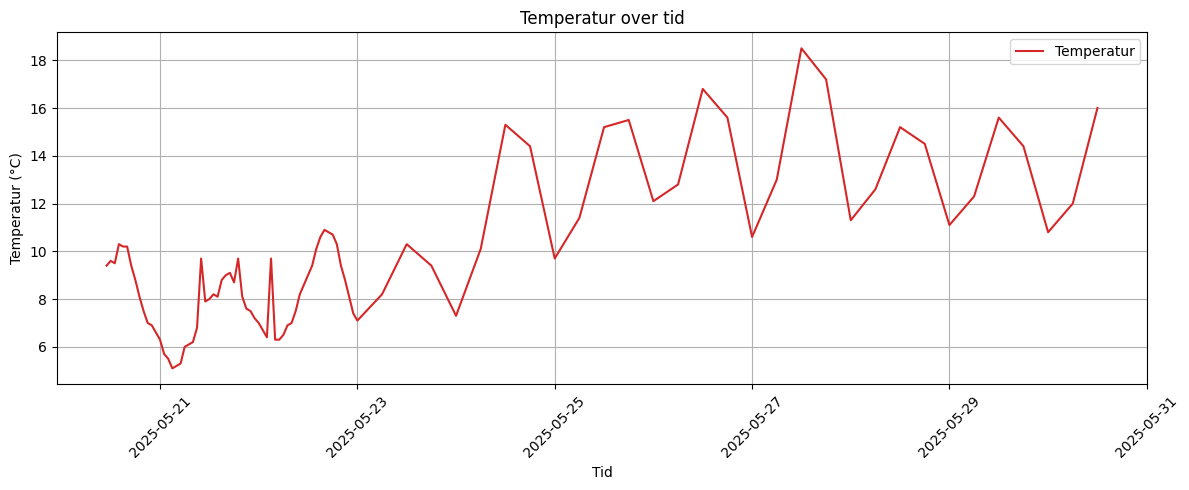


Gjennomsnittstemperaturer:
Tidspunkt
Dag:     10.714000
Natt:     8.392857
Name: temperature, dtype: float64

Differanse dag og natt: 2.32 °C


C:\Users\nicol\AppData\Local\Temp\ipykernel_23084\944489310.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gjennomsnitt.index, y=gjennomsnitt.values, palette="coolwarm")


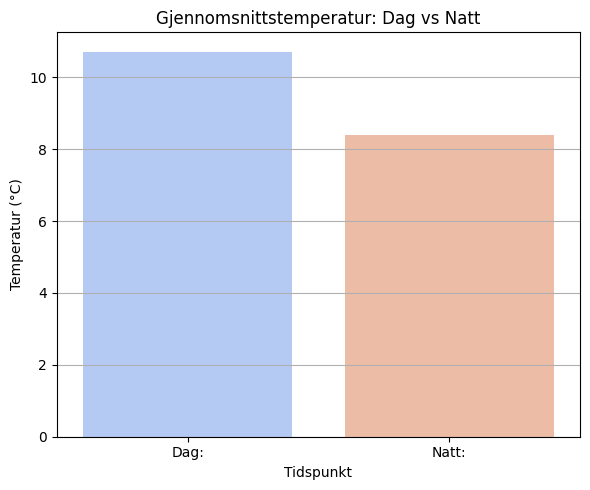

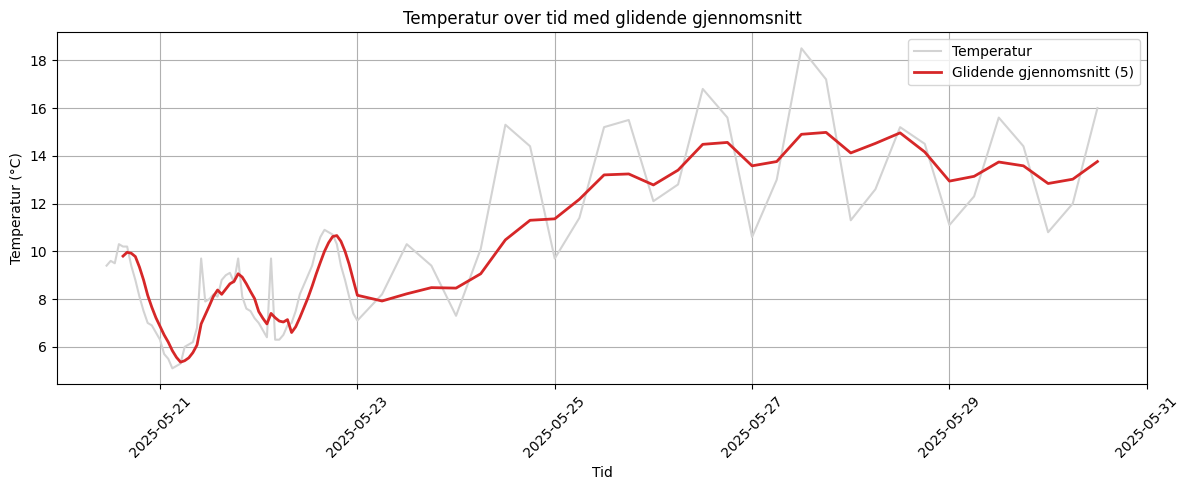

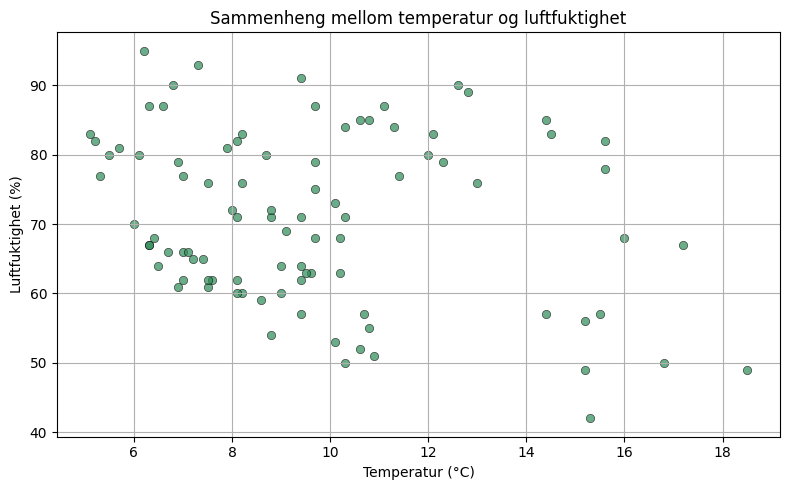

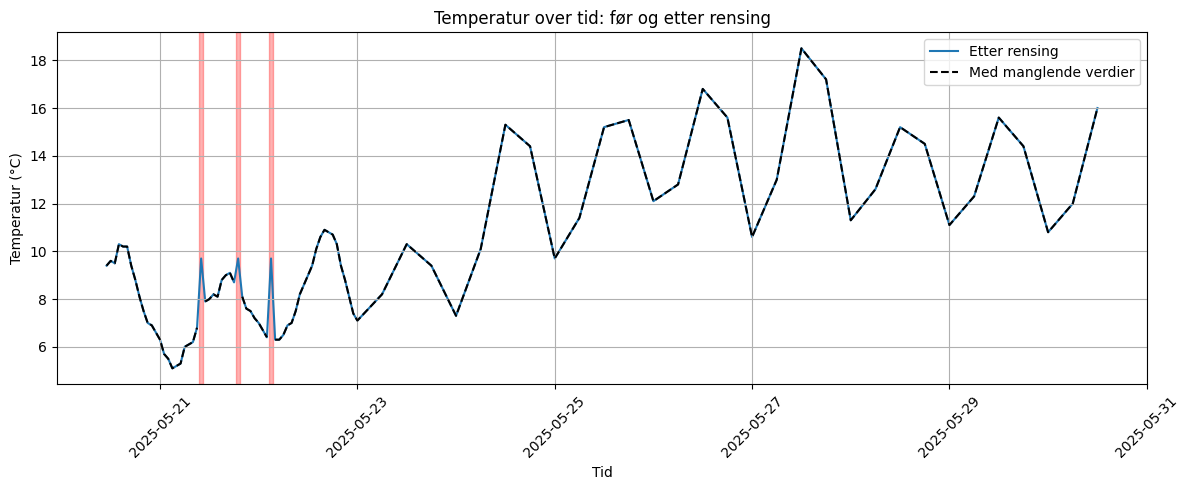

In [273]:
"""Oppgave 5: Visualisering"""

def temp_over_tid_plot(df_fixed):
    """Lager en linjegraf av temperaturen over tid"""
    plt.figure(figsize=(12, 5)) #Størrelse på figuren
    plt.plot(df_fixed["time"], df_fixed["temperature"], color="tab:red", label="Temperatur") #Plotter temp mot tid
    plt.title("Temperatur over tid") #Tittel på grafen
    plt.xlabel("Tid") #X-akse tittel
    plt.ylabel("Temperatur (°C)") #Y-akse tittel
    plt.xticks(rotation=45) #Roterer tidsetiketter for bedre lesbarhet
    plt.legend() #Viser etikett
    plt.grid(True) #Viser rutenett
    plt.tight_layout() #Hindrer overlapp
    plt.show()
#Et linjediagram er ideelt for å vise trender over tid. 
#Her ser vi tydelig hvordan temperaturen endrer seg time for time over flere dager.

temp_over_tid_plot(df_fixed)

def dag_vs_natt_plot(df_fixed):
    """Lager en søylediagram av gjennomsnittstemperatur for dag og natt"""
    gjennomsnitt = analyser_dagstemperatur(df_fixed) #Bruker funksjonen fra oppgave 4

    plt.figure(figsize=(6, 5))
    sns.barplot(x=gjennomsnitt.index, y=gjennomsnitt.values, palette="coolwarm")
    plt.title("Gjennomsnittstemperatur: Dag vs Natt")
    plt.ylabel("Temperatur (°C)")
    plt.xlabel("Tidspunkt")
    plt.grid(axis="y") #Rutenett på Y-aksen
    plt.tight_layout()
    plt.show()
#Et søylediagram er effektivt for å sammenligne gjennomsnitt. 
#Denne viser fint forskjellen på dag og natt

dag_vs_natt_plot(df_fixed)

def temp_med_glidende_snitt(df_fixed, vindu=5):
    """Temperatur over tid med glidende gjennomsnitt"""
    plt.figure(figsize=(12, 5))
    plt.plot(df_fixed["time"], df_fixed["temperature"], color="lightgray", label="Temperatur") #Originaldata
    plt.plot(df_fixed["time"], df_fixed["temperature"].rolling(vindu).mean(), color="tab:red", linewidth=2, label=f"Glidende gjennomsnitt ({vindu})")
    plt.title("Temperatur over tid med glidende gjennomsnitt")
    plt.xlabel("Tid")
    plt.ylabel("Temperatur (°C)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
#Det glidende gjennomsnittet jevner ut temperaturvariasjonene,
#slik at trenden over tid blir lettere å tolke visuelt

temp_med_glidende_snitt(df_fixed)

def scatter_temp_vs_fuktighet(df_fixed):
    """Lager et scatterplot for å vise forholdet mellom temperatur og luftfuktighet"""
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df_fixed,
        x="temperature",
        y="humidity",
        color="seagreen",  #Velger ønsket farge
        edgecolor="black",  #Gir punktene en kontrastkant
        alpha=0.7  #Gjør punktene litt gjennomsiktige for bedre oversikt
    )
    plt.title("Sammenheng mellom temperatur og luftfuktighet")
    plt.xlabel("Temperatur (°C)")
    plt.ylabel("Luftfuktighet (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
#En scatterplot er nyttig for å identifisere korrelasjoner mellom variabler. 
#Her kan vi se hvordan temperatur og fuktighet henger sammen. 

scatter_temp_vs_fuktighet(df_fixed)

df_broken = formater_data(df_broken) #Sørger for at df_broken kan brukes i visualisering

def vis_manglende_vs_utfylt(df_broken, df_fixed):
    """Sammenligner temperatur over tid med og uten manglende verdier"""
    plt.figure(figsize=(12, 5))
    plt.plot(df_fixed["time"], df_fixed["temperature"], label="Etter rensing", color="tab:blue", zorder=1)
    plt.plot(df_broken["time"], df_broken["temperature"], label="Med manglende verdier", color="black", linestyle="--", zorder=2)
    
    #Finner og fremhever tidsperioder med manglende verdier i originalen
    manglende_tid = df_broken["temperature"].isnull()

    if manglende_tid.any():
        for i in range(len(manglende_tid)):
            if manglende_tid.iloc[i]:
                time = df_broken["time"].iloc[i]
                plt.axvspan(time - pd.Timedelta(minutes=30),
                            time + pd.Timedelta(minutes=30),
                            color='red', alpha=0.3, zorder=0)
    plt.title("Temperatur over tid: før og etter rensing")
    plt.xlabel("Tid")
    plt.ylabel("Temperatur (°C)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
#Denne grafen hjelper oss forstå hvordan manglende verdier kan påvirke visualiseringen.
#Ved å sammenligne renset og urenset datasett, ser vi hullene som røde områder.

vis_manglende_vs_utfylt(df_broken, df_fixed)


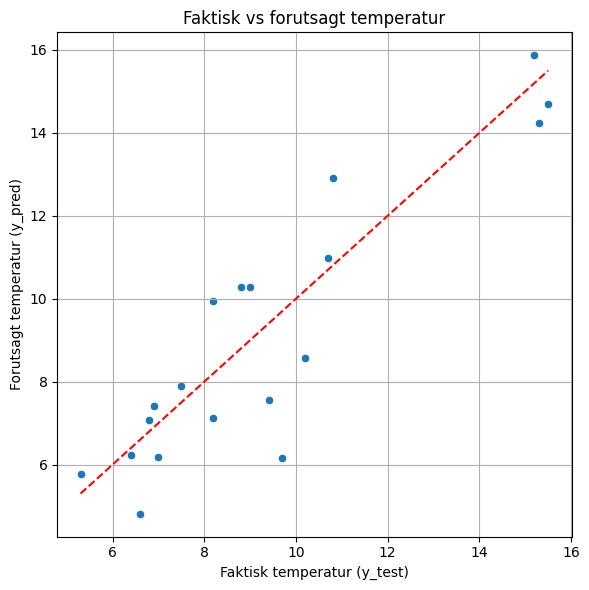

Mean Absolute Error (MAE): 1.15 °C
Dette betyr at gjennomsnittlig er modellens temperaturforutsigelser feil med omtrent 1.15 °C.
Mean Squared Error (MSE): 2.00
Root Mean Squared Error (RMSE): 1.41 °C
R² score: 0.78


C:\Users\nicol\AppData\Local\Temp\ipykernel_23084\1414394995.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=last_time + timedelta(hours=1), periods=24, freq="H")


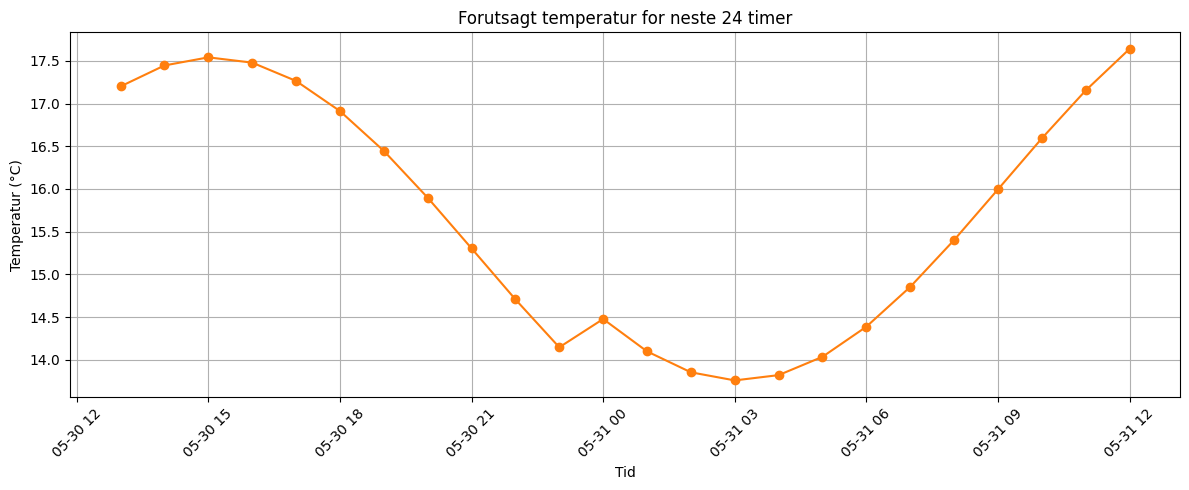

Grafen viser temperaturforutsigelser for de neste 24 timene, basert på en 
lineær regresjonsmodell trent på værdata fra API-en.
Modellen bruker blant annet luftfuktighet, 
skydekke, lufttrykk og klokkeslett som forklaringsvariabler.

Ved å bruke trigonometiske funksjoner (hour_sin og hour_cos) klarer modellen å 
forstå det sykliske mønsteret i temperatur over døgnet,
for eksempel at temperaturen ofte er høyest om ettermiddagen og lavest 
tidlig på morgenen. Figuren viser en naturlig temperaturkurve, hvor temperaturen 
stiger fra morgen til ettermiddag, faller gradvis gjennom kvelden og natten og mot slutten stiger igjen når solen går opp
Dette mønsteret bekrefter at modellen har lært dag/natt-rytmen, og prediksjonene
gir mening i en realistisk kontekst.


In [274]:
"""Oppgave 6: Prediktiv analyse"""

#Legger til tidsbaserte funksjoner (timer og dager)
df_fixed["hour"] = df_fixed["time"].dt.hour
df_fixed["dayofyear"] = df_fixed["time"].dt.dayofyear

#Gjør timen syklisk (for bedre modell)
df_fixed["hour_sin"] = np.sin(2 * np.pi * df_fixed["hour"] / 24)
df_fixed["hour_cos"] = np.cos(2 * np.pi * df_fixed["hour"] / 24)

#Uavhengige variabler (forklaringsvariabler)
X = df_fixed[["humidity", "cloud_cover", "pressure", "hour_sin", "hour_cos", "dayofyear"]]

#Målvariabel (det vi skal forutsi)
y = df_fixed["temperature"]

#Splitter dataene i treningssett og testsett
#Dette gjør at 80% av dataen vil bli brukt til trening og 20% til testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Lager og trener modellen
modell = LinearRegression()
modell.fit(X_train, y_train)

#Lager forutsigelser på testdata
y_pred = modell.predict(X_test)

#Plotter faktisk vs. forutsagt temperatur
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Faktisk temperatur (y_test)")
plt.ylabel("Forutsagt temperatur (y_pred)")
plt.title("Faktisk vs forutsagt temperatur")
plt.grid(True)
plt.tight_layout()
plt.show()

#Gir forutsagte verdier
y_pred = modell.predict(X_test)

#Evaluerer modellens ytelse med ulike feilmål
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#Printer resultat
print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
print(f"Dette betyr at gjennomsnittlig er modellens temperaturforutsigelser feil med omtrent {mae:.2f} °C.")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} °C")
print(f"R² score: {r2:.2f}")

#Genererer fremtidige tidspunkt (neste 24 timer)
last_time = df_fixed["time"].max()
future_times = pd.date_range(start=last_time + timedelta(hours=1), periods=24, freq="H")

#Lager fremtidig datasett med gjennomsnittlige værverdier
future_df = pd.DataFrame({
    "time": future_times,
    "humidity": df_fixed["humidity"].mean(),
    "wind_speed_mps": df_fixed["wind_speed_mps"].mean(), 
    "cloud_cover": df_fixed["cloud_cover"].mean(),
    "pressure": df_fixed["pressure"].mean()
})

#Legger til sykliske og tidsbaserte variabler
future_df["hour"] = future_df["time"].dt.hour
future_df["dayofyear"] = future_df["time"].dt.dayofyear
future_df["hour_sin"] = np.sin(2 * np.pi * future_df["hour"] / 24)
future_df["hour_cos"] = np.cos(2 * np.pi * future_df["hour"] / 24)

#Velger samme inputkolonner som brukt under trening
future_X = future_df[["humidity", "cloud_cover", "pressure", "hour_sin", "hour_cos", "dayofyear"]]

#Bruker modellen til å forutsi temperatur
future_df["predicted_temperature"] = modell.predict(future_X)

#Visualiserer forutsagte temperaturer
plt.figure(figsize=(12, 5))
plt.plot(future_df["time"], future_df["predicted_temperature"], marker='o', color="tab:orange")
plt.title("Forutsagt temperatur for neste 24 timer")
plt.xlabel("Tid")
plt.ylabel("Temperatur (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
print(
"""Grafen viser temperaturforutsigelser for de neste 24 timene, basert på en 
lineær regresjonsmodell trent på værdata fra API-en.
Modellen bruker blant annet luftfuktighet, 
skydekke, lufttrykk og klokkeslett som forklaringsvariabler.
\nVed å bruke trigonometiske funksjoner (hour_sin og hour_cos) klarer modellen å 
forstå det sykliske mønsteret i temperatur over døgnet,
for eksempel at temperaturen ofte er høyest om ettermiddagen og lavest 
tidlig på morgenen. Figuren viser en naturlig temperaturkurve, hvor temperaturen 
stiger fra morgen til ettermiddag, faller gradvis gjennom kvelden og natten og mot slutten stiger igjen når solen går opp
Dette mønsteret bekrefter at modellen har lært dag/natt-rytmen, og prediksjonene
gir mening i en realistisk kontekst."""
)